<h1 style="text-align: center"> Harvey Dataset Cleaning </h1>

In [1]:
import pandas as pd
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import re
import emoji
import inflect
from tqdm import tqdm
import copy
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import pickle
from sentence_transformers import SentenceTransformer,util
from sentence_transformers import SentencesDataset, LoggingHandler, losses
from nltk.corpus import words


/Users/savinaysingh/Documents/SavinayUTS/iLab/Code/iLab-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df=pd.read_csv('/Users/savinaysingh/Downloads/Hurricane_Harvey.csv', header= 0,
                        encoding= 'unicode_escape')

In [3]:
df.Tweet

0         If you do decide to drive in for #ColdplayHous...
1         As Hurricane Harvey is fast approaching, now i...
2         Is @JerryJordan_KTT providing live #HurricaneH...
3             I'm waiting for a Steve Harvey Hurricane meme
4         The name of the hurricane is Harvey ... Steve ...
                                ...                        
399401    Lawyers wanting to provide pro bono help in th...
399402    Hurricane Harvey: Alabamas largest church alr...
399403    Hurricane Harvey pressures already tight Houst...
399404    Our thoughts are with our neighbors in the Sou...
399405    Marylanders head to Texas to assist with Hurri...
Name: Tweet, Length: 399406, dtype: object

1. Abbreviation Handling
2. Spelling correction
3. Stop words removal if not using sentence transformer for contenxtual understanding
4. Lowercasing the sentences
5. Mentions and hashtags handling
6. Handling numerics
7. Handling Punctuations
8. Lemmatization
9. Removal of urls and unwanted noise
10. Handling emojis

In [4]:
import emoji


In [5]:
df['Tweet'].isna().sum()

490

In [6]:
df=df.dropna(subset=['Tweet'])

In [7]:
df['Tweet'].isna().sum()

0

In [8]:
def contains_emoji(text):
    return True in [emoji.is_emoji(t) for t in text]

# Apply the function to the DataFrame column
df['Tweet'].apply(contains_emoji)

0         False
1         False
2         False
3         False
4         False
          ...  
399401    False
399402    False
399403    False
399404    False
399405    False
Name: Tweet, Length: 398916, dtype: bool

In [9]:
df['Emoji']=df['Tweet'].apply(contains_emoji)

KeyboardInterrupt: 

In [ ]:
df['Emoji'].value_counts()

In [ ]:
df.Tweet[81648]

# 1. Abbreviation Handling

In [ ]:
sentences=list(df.Tweet)

In [ ]:
word_list=list(' '.join(sentences).split())

In [ ]:
# Case1: Words which are in uppercase have chances of being an abbreviation
capital_words=Counter([x for x in word_list if x.isupper()])

In [ ]:
# Observing top 150 capital words to search for abbreviations
capital_words.most_common(150)

In [ ]:
del capital_words['I']
del capital_words['A']


In [ ]:
X=[l[0] for l in capital_words.most_common(150)]
Y=[l[1] for l in capital_words.most_common(150)]
px.bar( x=X, y=Y)

In [ ]:
capital_words.most_common(150)

In [ ]:
capital_words.most_common(100)

In [ ]:
word_list=list(' '.join(sentences).split())

In [ ]:
# Importing all the stopwords from nltk library into a list
stop_words=stopwords.words('english')

In [72]:
# Importing all the english words from nltk library into a list
english_words=words.words()

In [73]:
english_words=[x.lower() for x in english_words]

In [74]:
# Case2: Words which are not in english words vocabulary and not in stop words and have length less than 5 have a tendency to be an abbreviation 
non_eng_words=[x for x in tqdm(word_list,total=len(word_list)) if len(x)<=5 and x.isalpha() and x.lower() not in english_words and x.lower() not in stop_words]


100%|█████████████████████████████| 5648006/5648006 [1:20:48<00:00, 1164.91it/s]


In [56]:
non_eng_words=Counter([x for x in non_eng_words])

In [57]:
non_eng_words.most_common(150)

[('heard', 191),
 ('doses', 92),
 ('mRNA', 81),
 ('died', 56),
 ('shots', 40),
 ('using', 32),
 ('women', 32),
 ('clots', 31),
 ('makes', 30),
 ('masks', 24),
 ('seems', 22),
 ('Ive', 20),
 ('app', 20),
 ('Im', 19),
 ('nodes', 19),
 ('types', 16),
 ('ones', 15),
 ('tests', 15),
 ('ive', 14),
 ('gets', 14),
 ('safer', 13),
 ('knows', 13),
 ('im', 12),
 ('rates', 12),
 ('rules', 11),
 ('means', 11),
 ('risks', 11),
 ('years', 11),
 ('kid', 11),
 ('cases', 10),
 ('eggs', 10),
 ('steps', 10),
 ('info', 10),
 ('mrna', 10),
 ('okay', 9),
 ('helps', 9),
 ('isnt', 8),
 ('weeks', 8),
 ('dna', 8),
 ('jabs', 7),
 ('vax', 7),
 ('says', 6),
 ('terms', 6),
 ('lives', 6),
 ('wants', 6),
 ('lasts', 6),
 ('gives', 5),
 ('cells', 5),
 ('ms', 5),
 ('takes', 5),
 ('wanna', 4),
 ('signs', 4),
 ('bells', 4),
 ('keeps', 4),
 ('kiil', 4),
 ('parts', 4),
 ('hasnt', 4),
 ('pigs', 4),
 ('areas', 4),
 ('gyms', 4),
 ('fda', 4),
 ('words', 4),
 ('names', 4),
 ('feet', 3),
 ('hands', 3),
 ('gonna', 3),
 ('Astra', 3)

In [62]:
# Some words removed as they are over-dominating and are not an abbreviation
del non_eng_words['heard']
del non_eng_words['doses']
del non_eng_words['died']
del non_eng_words['shots']

<p style="color:black;font-size:18px;"> The bar plot below shows the top potential abbreviations according to case 2
</p>

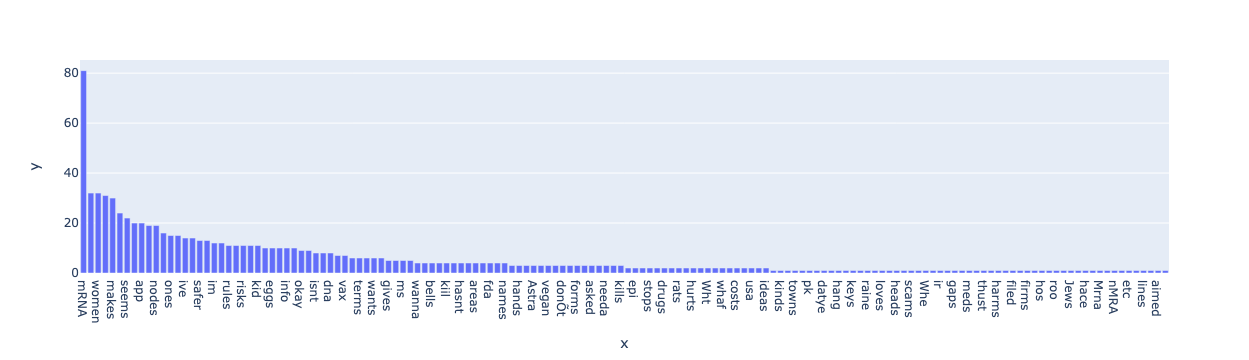

In [63]:
X=[l[0] for l in non_eng_words.most_common(150)]
Y=[l[1] for l in non_eng_words.most_common(150)]
px.bar( x=X, y=Y)

# 2. Handling Apostophe

In [8]:
number_sent_apostophe=len([x for x in sentences if "'" in x])

In [9]:
print("Percentage of sentences with apostophe is: ",number_sent_apostophe/len(sentences)*100,"%")

Percentage of sentences with apostophe is:  16.710642040457344 %


In [10]:
# Converting the words having apostophe into their root form
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"there\'s", "there is", phrase)
    phrase = re.sub(r"it\'s", "it is", phrase)
    phrase = re.sub(r"he\'s", "he is", phrase)
    phrase = re.sub(r"she\'s", "she is", phrase)
    phrase = re.sub(r"how\'s", "how is", phrase)
    phrase = re.sub(r"let\'s", "let is", phrase)
    phrase = re.sub(r"so\'s", "so is", phrase)
    phrase = re.sub(r"what\'s", "what is", phrase)
    phrase = re.sub(r"when\'s", "when is", phrase)
    phrase = re.sub(r"where\'s", "where is", phrase)
    phrase = re.sub(r"why\'s", "why is", phrase)
  
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [11]:
[x for x in sentences if "won't" in x]

["People are going bankrupt over medical debt. $12k a year minus the VAT won't put a dent in that. Let'… https://t.co/i31T5Kg5LE",
 "There's a new drug in town and you won't want to miss its catastrophic effects on tonight's all-new NCIS: Los Angeles. Stream i…",
 '"Let me tell you something good... Beel won\'t destroy the human world, Do you know why? It\'s because I\'m his parent… https://t.co/H5iBsk2BxX',
 "Translation: we have a climate policy but that won't stop us from investing in things that destroy the climate, because maki…",
 "So long as I keep moving, play loud music to drown him, play videogames or watch TV shows or movies, I won't have t… https://t.co/fJpK9wA2W6",
 "Why won't my blue_aura_Explosion spawn!?!?!? Because the naming convention is aura_blue_Explosion ... #indiedev https:…",
 "The story that won't die. 2 more dogs. Cane Corsos. https://t.co/7oQxpwqIKh",
 "despite immature fans wanting him gone, I don't have the fear that jongdae will leave bc I know exo won't L

In [12]:
sentences=[decontracted(x) for x in sentences]

In [13]:
[x for x in sentences if "won't" in x]

[]

In [14]:
number_sent_apostophe=len([x for x in sentences if "'" in x])

In [15]:
print("Percentage of sentences with apostophe is: ",number_sent_apostophe/len(sentences)*100,"%")

Percentage of sentences with apostophe is:  8.988566402814424 %


In [16]:
data['text'] =sentences

# 3. Mentions and Hashtags

In [ ]:
# Remove mentions -> they don't tell emotions
# Seperate hashtags 

# 4. Lowercasing the sentences

In [ ]:
df['Tweet'] = df['Tweet'].str.lower()


# 5. Punctuations can be important

In [ ]:
## Emotions out of punctuations

# 6. Numerics can be important

# 7. Removal of emojis here 

In [ ]:
# 18 sept: peer feedback & ppt
# Need to update notion ASAP

# By 14th sept and mention in the ppt (we need to showcase the results as well)
# 1. Dataset ready ✅
# 2. faq ready ✅
# 3. Disaster Classification ready ⏰
# 4. Data cleaned ⏰
# 5. Finalised LLM open source ⏰
# 6. Comparison metrics ready: Falcon v/s Flan T5 ⏰

In [77]:
df.Tweet

0         If you do decide to drive in for #ColdplayHous...
1         As Hurricane Harvey is fast approaching, now i...
2         Is @JerryJordan_KTT providing live #HurricaneH...
3             I'm waiting for a Steve Harvey Hurricane meme
4         The name of the hurricane is Harvey ... Steve ...
                                ...                        
399401    Lawyers wanting to provide pro bono help in th...
399402    Hurricane Harvey: Alabamas largest church alr...
399403    Hurricane Harvey pressures already tight Houst...
399404    Our thoughts are with our neighbors in the Sou...
399405    Marylanders head to Texas to assist with Hurri...
Name: Tweet, Length: 398916, dtype: object

In [79]:
def extract_words_after_special_chars(text):
    # Use regex to find words following special characters
    matches = re.findall(r'[!@#$%^&*():;,.<>?/\|{}=_+-]', text)
    
    # Filter out empty strings and remove special characters
    words = [word.strip('!@#$%^&*():;,.<>?/\|{}=_+-') for word in matches]
    
    return words

# Apply the function to the DataFrame column
df['words_after_special_chars'] = df['Tweet'].apply(extract_words_after_special_chars)


In [12]:
list(df.Tweet)

['If you do decide to drive in for #ColdplayHouston be prepared to stay because there might not be gas to get you home. #HurricaneHarvey',
 'As Hurricane Harvey is fast approaching, now is the time to do what you can to prepare your property to minimize... http://fb.me/8TrKU8IqR\xa0',
 'Is @JerryJordan_KTT providing live #HurricaneHarvey coverage for @KicknTheTires ?\r\n\r\n#askingforafriend',
 "I'm waiting for a Steve Harvey Hurricane meme",
 'The name of the hurricane is Harvey ... Steve Harvey',
 "@realDonaldTrump is a shitshow when nothing's going on.\r\n\r\nAaaaand here comes #HurricaneHarvey\r\n\r\nBest of luck, Gulf Coast\r\n\r\n#shitshow",
 "If you're able, give blood at @RedCross.  Donate, blood, time, money, skills.  Hurricane Harvey is a bad one.  #unite #help #serve",
 'Summary for Hurricane Harvey (AT4/AL092017) http://fb.me/16OrHtjha\xa0',
 "NASA: RT ESA_EO: Just in! #Sentinel3 measures #HurricaneHarvey's temperature as the #storm quickly approaches the ? https://twitter.